In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA

from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

In [8]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

vfield = np.load(fpath, allow_pickle=True)
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

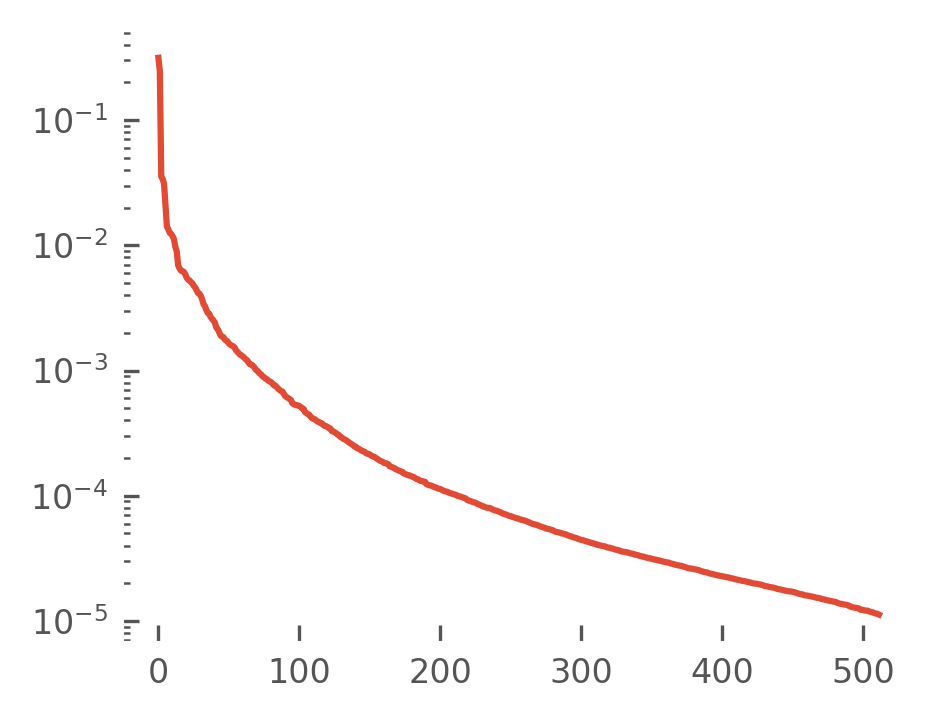

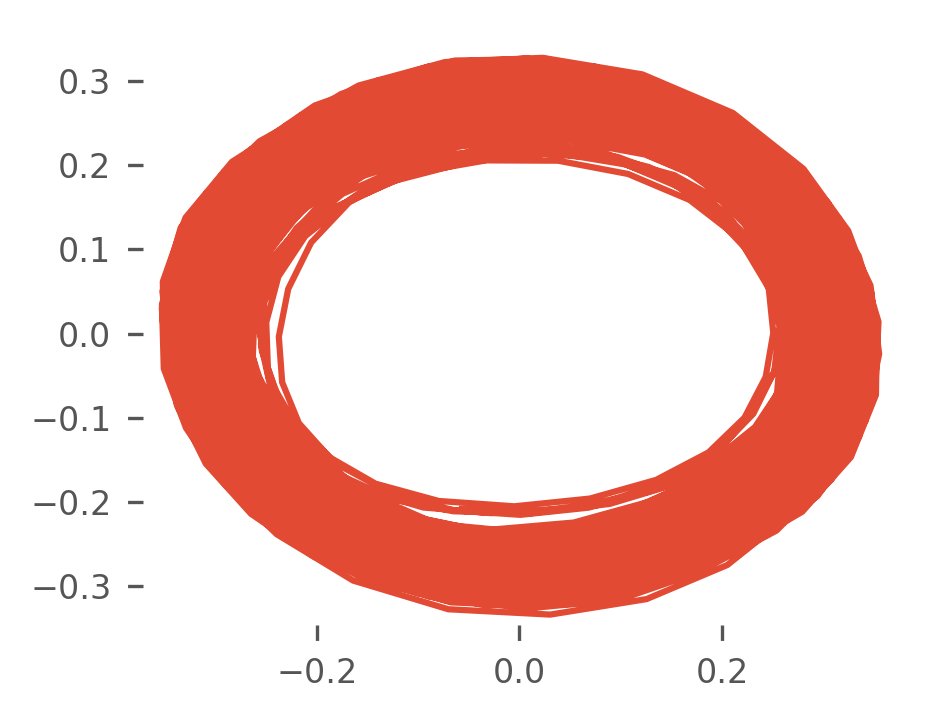

In [9]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

## Show low-rank structure
plt.figure()
plt.plot(np.arange(n_components), pca.explained_variance_ratio_)
plt.semilogy()

## Plot trajectory
plt.figure()
plt.plot(X_ts[:, 0], X_ts[:, 1])

In [10]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

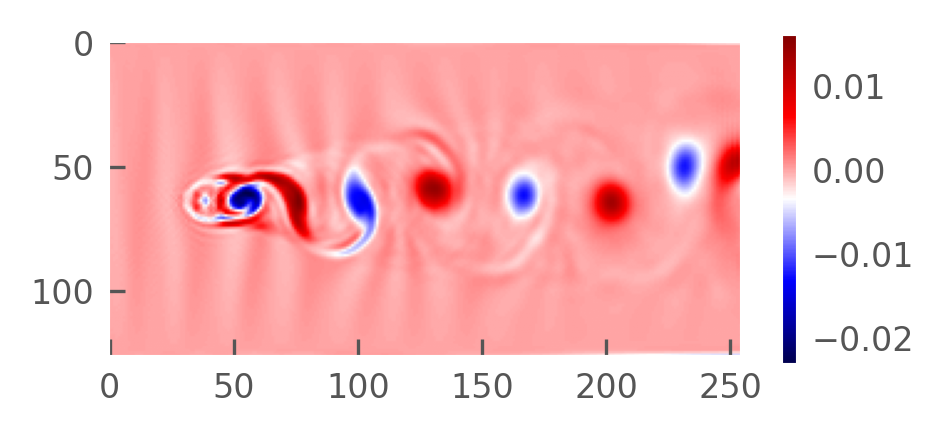

In [11]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

In [36]:
stride = 1
start = 2048  # ignore transient
num_modes = 64
context_length = 512
prediction_length = 128
time_indices = [15, 31, 63, 127]

strided_X = X_ts[start::stride]

In [ ]:
from collections.abc import Iterator
from dataclasses import dataclass

from neuralop import H1Loss
from neuralop.models import FNO
from neuralop.training import Trainer


@dataclass
class Dataset(torch.utils.data.Dataset):
    traj: torch.Tensor

    def __len__(self) -> int:
        return self.traj.shape[0] - 1

    def __getitem__(self, idx: int) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        x = self.traj[idx]
        y = self.traj[idx + 1]
        return {
            "x": torch.from_numpy(x).unsqueeze(0).float(),
            "y": torch.from_numpy(y).unsqueeze(0).float(),
        }


device_rank = 0
device = f"cuda:{device_rank}"

end_time = context_length + prediction_length

context_window = strided_X[:context_length]
prediction_window = strided_X[context_length:end_time]

batch_size = 128
num_epochs = 1000

# preprocess training context
train_loader = torch.utils.data.DataLoader(
    Dataset(context_window),
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    Dataset(prediction_window), batch_size=batch_size, num_workers=0, pin_memory=True
)

operator = FNO(n_modes=(8 * num_modes,), hidden_channels=256, in_channels=1, out_channels=1).to(device)
trainer = Trainer(model=operator, n_epochs=num_epochs, verbose=True, device=device)
optimizer = torch.optim.AdamW(operator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=context_length // batch_size * num_epochs)
loss_fn = H1Loss(d=1)

trainer.train(
    train_loader=train_loader,
    test_loaders={"eval": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    training_loss=loss_fn,
)

Training on 511 samples
Testing on [127] samples         on resolutions ['eval'].
Raw outputs of shape torch.Size([128, 1, 512])
[0] time=0.11, avg_loss=0.8118, train_err=103.7028
Eval: eval_l2=1.1627
[1] time=0.11, avg_loss=0.6999, train_err=89.4177
Eval: eval_l2=0.6722
[2] time=0.11, avg_loss=0.6699, train_err=85.5842
Eval: eval_l2=0.5942
[3] time=0.11, avg_loss=0.5186, train_err=66.2466
Eval: eval_l2=0.5631
[4] time=0.11, avg_loss=0.4954, train_err=63.2833
Eval: eval_l2=0.4790
[5] time=0.11, avg_loss=0.4845, train_err=61.8910
Eval: eval_l2=0.4655
[6] time=0.11, avg_loss=0.4557, train_err=58.2153
Eval: eval_l2=0.4740
[7] time=0.12, avg_loss=0.4559, train_err=58.2453
Eval: eval_l2=0.4472
[8] time=0.12, avg_loss=0.4482, train_err=57.2581
Eval: eval_l2=0.4443
[9] time=0.12, avg_loss=0.4368, train_err=55.8020
Eval: eval_l2=0.4396
[10] time=0.11, avg_loss=0.4307, train_err=55.0247
Eval: eval_l2=0.4242
[11] time=0.11, avg_loss=0.4234, train_err=54.0933
Eval: eval_l2=0.4146
[12] time=0.11, 

{'train_err': 2.357977867126465,
 'avg_loss': 0.018457752384551582,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.11571264907252043,
 'eval_l2': tensor(0.1279, device='cuda:0')}

In [67]:
def rollout(ic: torch.Tensor, model: torch.nn.Module, num_steps: int) -> torch.Tensor:
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        state = model(state)
        traj.append(state)
    return torch.cat(traj, dim=0)

In [68]:
prediction = (
    rollout(
        torch.from_numpy(context_window[-1]).float().to(device).unsqueeze(0).unsqueeze(0),
        model=operator,
        num_steps=prediction_length,
    )[1:]
    .squeeze()
    .detach()
    .cpu()
    .numpy()
)
prediction_traj = np.concatenate([context_window, prediction], axis=0)

In [ ]:
def plot_predicted_flow(
    prediction: torch.Tensor,
    trajectory: torch.Tensor,
    eigenvectors: torch.Tensor,
    num_modes: int,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    time_indices: list[int] | None = None,
    save_path: str | None = None,
    camera_ready: bool = False,
    stride: int = 1,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
    **kwargs,
):
    recon = reconstruct(prediction[:, :num_modes], eigenvectors, modes=num_modes)
    recon = recon.reshape(-1, shape[0], shape[1])
    groundtruth = reconstruct(trajectory[:, :num_modes], eigenvectors, modes=num_modes)
    groundtruth = groundtruth.reshape(-1, shape[0], shape[1])
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    if time_indices is None:
        time_indices = list(range(0, groundtruth.shape[0], stride))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = recon[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

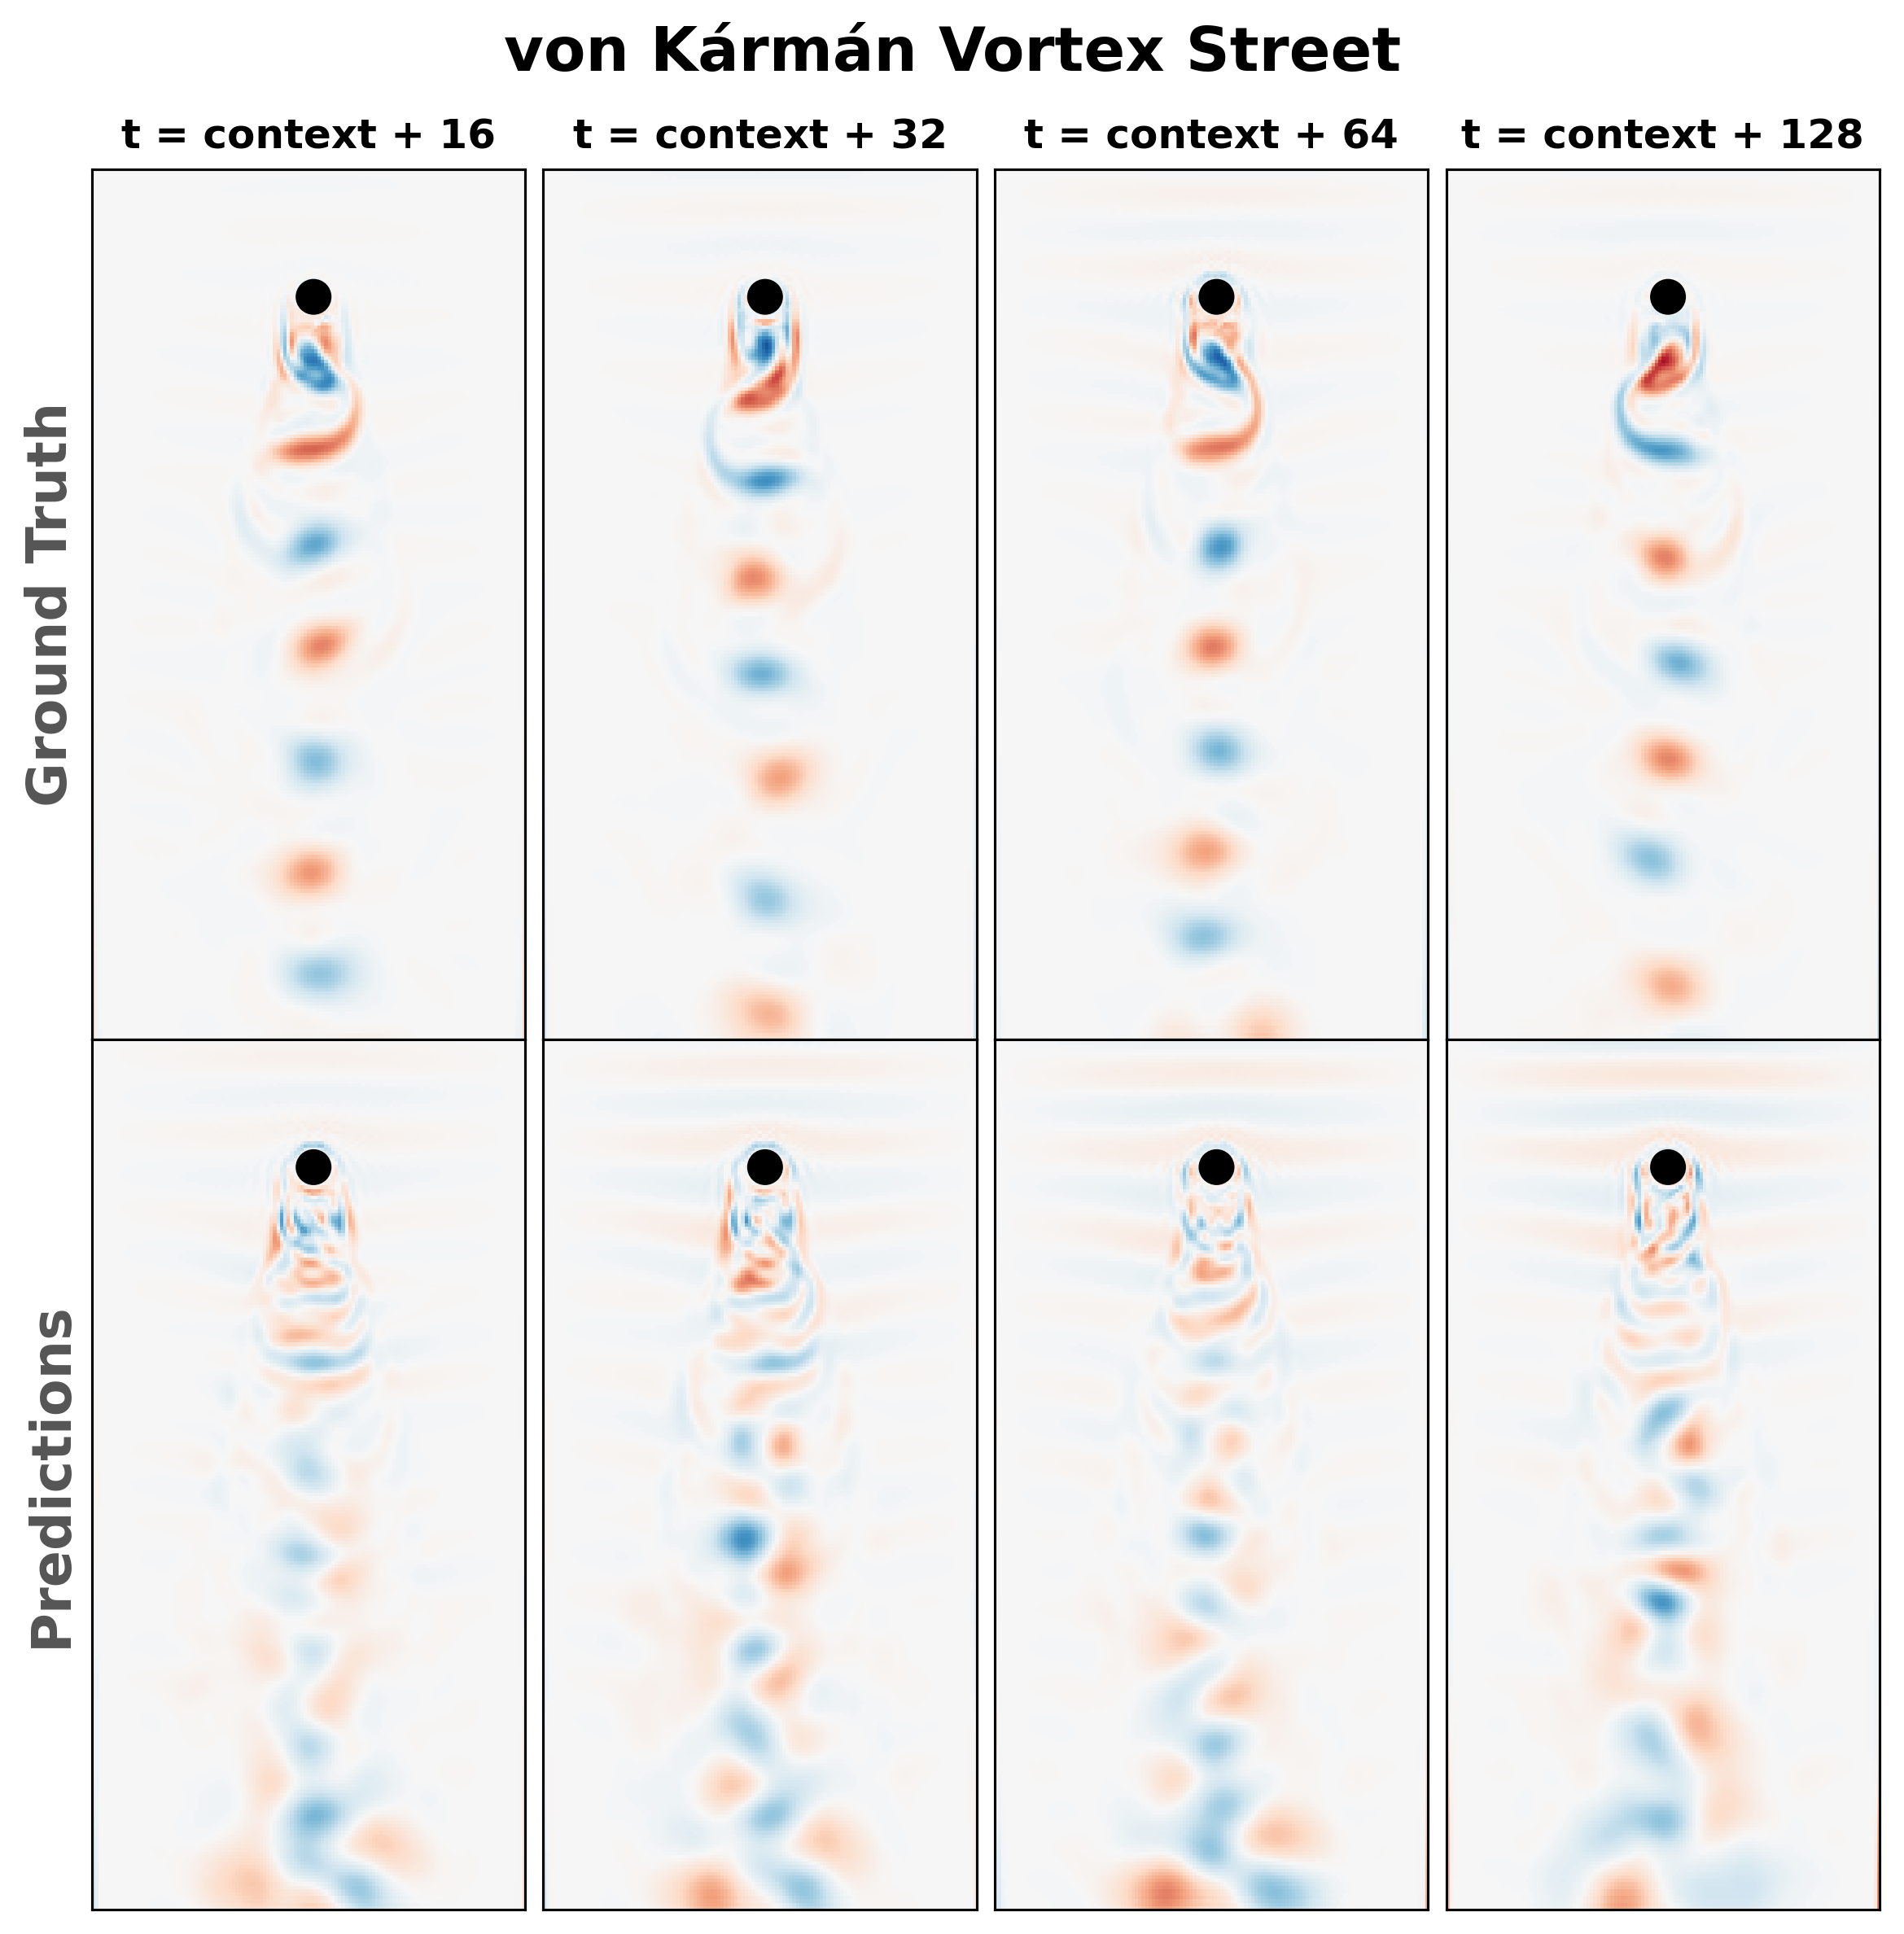

In [ ]:
plot_predicted_flow(
    prediction,
    prediction_window,
    eigenvectors,
    num_modes=num_modes,
    time_indices=[15, 31, 63, 127],
    cmap_name="RdBu",
    camera_ready=False,
    base_figsize=(4, 4),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)